#**Battle of Neighborhood**

##**Table of contents**


*   Business understanding
*   Data requirements
*   Data collection
*   Data visualization
*   Data understanding
*   Data analytics
*   Model evaluation
*   Result analysis









#Business understanding 

####Chennai is one of the largest cultural, economic and educational centres of South India. Chennai's various recreational spots attracts a huge amount of tourists. Considering the mobility across the city being it tourists, college students or office goers, starting a cafe business at a right spot will be a great success. 

####This project analyses various aspects such as population density, recreational centers, existing food outlets, etc. and suggests a right locality for opening a cafe.

Importing required packages.

In [20]:
import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


#Data requirements
####Various aspects such as list of areas in the city, population distribution, recreational spots, available restaurants in each locality, etc. are required for analysing our problem. Let us discuss the collection of these data in the following section.

#Data collection
####The primary data to be collected is list of latitudes and longitudes of Chennai city. Let us collect this information from https://chennaiiq.com/chennai/latitude_longitude_areas.asp. We will be using BeautifulSoup to scrap the necessary details from the above link. The processed data will be passed to Foursquare API in order to extract further information regarding the localities.

In [21]:
url = 'https://chennaiiq.com/chennai/latitude_longitude_areas.asp'

html = requests.get(url)


soup = BeautifulSoup(html.text, 'html.parser')
table = soup.find("table", attrs={"class": "TBox"})

table_data = []
index = ['S.No.', 'Location', 'Latitude', 'Longitude']
for tr in table.find_all("tr", attrs={"class": "tab"}):
    t_row = {}
    for td, th in zip(tr.find_all("td"), index): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

chennai_data = pd.DataFrame(table_data[:-1], columns=index)
chennai_data.drop(columns=['S.No.'], inplace=True)
chennai_data.at[0,'Location'] = 'Adyar Bus Debot'
chennai_data.rename(columns={'Location': 'Neighborhood'}, inplace=True)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,"12°59'50"" N","80°15'25"" E"
1,Adyar Signal,"13°00'23"" N","80°15'27"" E"
2,Alandur,"13°00'28"" N","80°12'35"" E"
3,Ambattur,"13°06'36"" N","80°10'12"" E"
4,Anna Arch,"13°04'28"" N","80°13'06"" E"


In [22]:
#Converting latitude and longitude to decimal which can be used in foursquare.

def LL_Convert(s):

    degrees, minutes, seconds, direction = re.split('[°\'"]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    
    if direction in ('S','W'):
        dd*= -1
    return dd

chennai_data['Latitude'] = chennai_data['Latitude'].apply(LL_Convert)
chennai_data['Longitude'] = chennai_data['Longitude'].apply(LL_Convert)
print(chennai_data.shape)
chennai_data.head()


(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,12.997222,80.256944
1,Adyar Signal,13.006389,80.257500
2,Alandur,13.007778,80.209722
3,Ambattur,13.110000,80.170000
4,Anna Arch,13.074444,80.218333


In [23]:
#Finding latitude and longitude of Chennai.

address = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of chennai are {}, {}.'.format(latitude, longitude))



The geographical coordinate of chennai are 13.0836939, 80.270186.


#Data visualization

####Follium is used to plot the geographical data and visualize the Chennai city. Further bar graphs will be used to have a low level visualization later in this project.

In [24]:
#Visualize using follium
chennai_map = folium.Map(location=[latitude, longitude], zoom_start=11)    
chennai_map

In [25]:
CLIENT_ID = 'GYALT3OYLYVKW2VTJS2IIIU2SKZCJJFQW5W0ZP1ZLTKPLXBZ' # your Foursquare ID
CLIENT_SECRET = 'BPMJHGT3UYSTKKAUAM4I4YW1XQEMCS3U4GXWTJ0FPXT2RDPM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [26]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
chennai_venues = getNearbyVenues(names=chennai_data['Neighborhood'],
                                   latitudes=chennai_data['Latitude'],
                                   longitudes=chennai_data['Longitude']
                                  )
chennai_venues.head()

Adyar Bus Debot
Adyar Signal
Alandur
Ambattur
Anna Arch
Anna Nagar Roundana
Anna Nagar West Terminus
Anna Statue
Anna University Entrance
Avadi
AVM Studio
Ayyappa Temple
Basin Bridge
Chennai Airport
Chennai Central
Chennai Mofussil Bus Terminas (CMBT)
Chennai Trade Center
Chepaukam Stadium
chetput
Chintadripet
Chintamani Signal
Chola
Church Park
CIPET
CIT Nagar Roundana
CLRI
DPI
Egmore Railway Station
Ethiraj College
Gemini Flyover
Greams Road
Guindy Race Course
Guindy Railway Station
HTL Colony
IIT Madras
Indra Nagar, Adyar
Isphani
Kamarajar Arangam
Kapaleeswarar Temple
Kasi Viswanathar Temple
Kasturiba Nagar, Adyar
Kathipara Junction
Kodampakkam
Korukkupet
Koyambedu Omni Bus Terminus
Koyambedu Super Market
Le Meridian
Light House
Loyolo College
Madhavaram
Madhya Kailash
Mambalam
Manali
Minambakkam
MIOT Hospital
MMM Hospital
MRTS
Mugappair East Terminus
Mugappair West
Music Academy
Nandanam Signal
Nanganallur
Nehru Nagar, Adyar
Newaharlal Nehru Stadium
Nungampakkam Railway Station
Pan

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
2,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
3,Adyar Bus Debot,12.997222,80.256944,Barbeque N Biryani,12.995907,80.256011,BBQ Joint
4,Adyar Bus Debot,12.997222,80.256944,Domino's Pizza,13.001470,80.256626,Pizza Place


#Data understanding

####Let's try to understand the available raw data. First let us group the data based on the neighborhood. Then we shall pick top 10 common venues for each neighborhood. By doing so we will get a better clarity on the data distribution. 

In [28]:
#A total of 1019 venues were obtained. Now lets check the number of venues returned per neighborhood.
chennai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AVM Studio,6,6,6,6,6,6
Adyar Bus Debot,16,16,16,16,16,16
Adyar Signal,24,24,24,24,24,24
Alandur,12,12,12,12,12,12
Ambattur,2,2,2,2,2,2
Anna Arch,11,11,11,11,11,11
Anna Nagar Roundana,19,19,19,19,19,19
Anna Nagar West Terminus,10,10,10,10,10,10
Anna Statue,10,10,10,10,10,10


In [29]:
#Analyze each neighborhood
#one hot encoding
chn_onehot = pd.get_dummies(chennai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chn_onehot['Neighborhood'] = chennai_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [chn_onehot.columns[-1]] + list(chn_onehot.columns[:-1])
chn_onehot = chn_onehot[fixed_columns]

chn_onehot.head()

,Neighborhood,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,Boutique,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Café,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Hookah Bar,Hotel,Hotel Bar,Hyderabadi Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Nightclub,Noodle House,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Pool Hall,Print Shop,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Tailor Shop,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Train,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Zoo Exhibit
0,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adyar Bus Debot,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adyar Bus Debot,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 137 uniques categories.


In [31]:
#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
chn_grouped = chn_onehot.groupby('Neighborhood').mean().reset_index()
chn_grouped.head()

,Neighborhood,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,Boutique,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Café,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Hookah Bar,Hotel,Hotel Bar,Hyderabadi Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Nightclub,Noodle House,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Pool Hall,Print Shop,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Tailor Shop,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Train,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Zoo Exhibit
0,AVM Studio,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.500000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,Adyar Bus Debot,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.125,0.0625,0.062500,0.0,0.000000,0.0,0.000000,0.0,0.0625,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.062500,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0625,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0625,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Adyar Signal,0.0,0.000000,0.0,0.041667,0.0,0.0,0.0,0.000,0.0000,0.041667,0.0,0.000000,0.0,0.041667,0.0,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.041667,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.041667,0.0,0.041667,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.291667,0.041667,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.041667,0.0,0.0,0.000

In [32]:
#Let's print each neighborhood along with the top 5 most common venues

num_top_venues = 5

for hood in chn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = chn_grouped[chn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----AVM Studio----
                venue  freq
0   Indian Restaurant  0.50
1               Hotel  0.17
2             Theater  0.17
3       Movie Theater  0.17
4  African Restaurant  0.00


----Adyar Bus Debot----
                  venue  freq
0  Fast Food Restaurant  0.12
1     Indian Restaurant  0.12
2      Asian Restaurant  0.12
3                Bakery  0.06
4           Pizza Place  0.06


----Adyar Signal----
                     venue  freq
0        Indian Restaurant  0.29
1  North Indian Restaurant  0.08
2              Coffee Shop  0.08
3       Italian Restaurant  0.04
4                Bookstore  0.04


----Alandur----
                     venue  freq
0              Bus Station  0.17
1        Indian Restaurant  0.17
2                 Bus Line  0.08
3               Restaurant  0.08
4  South Indian Restaurant  0.08


----Ambattur----
                           venue  freq
0                    Bus Station   0.5
1      Indian Chinese Restaurant   0.5
2             African Restaurant  

In [33]:
#Let's append it to a dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chn_grouped['Neighborhood']

for ind in np.arange(chn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AVM Studio,Indian Restaurant,Movie Theater,Hotel,Theater,Farmers Market,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fast Food Restaurant
1,Adyar Bus Debot,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Breakfast Spot,Dessert Shop,Café,Sandwich Place,Fried Chicken Joint,Fruit & Vegetable Store,Middle Eastern Restaurant
2,Adyar Signal,Indian Restaurant,North Indian Restaurant,Coffee Shop,Italian Restaurant,Bookstore,Electronics Store,Clothing Store,Fast Food Restaurant,Rock Club,Movie Theater
3,Alandur,Bus Station,Indian Restaurant,Metro Station,Restaurant,South Indian Restaurant,Bar,Bus Line,Train,Hotel,Airport
4,Ambattur,Indian Chinese Restaurant,Bus Station,Fast Food Restaurant,Fried Chicken Joint,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Farmers Market,Convenience Store


#Data analytics
####Now that we have grouped the data based on the neighborhood and picked top 10 common venues, we shall further gain some insights by statistical means. Since we have unlabelled data points, let us use K-Means clustering algorithm and try to group these data points to relevant clusters. 

####However when it comes to K-Means clustering, it is tricky to choose a right K-value. Let us run the clustering for various K values and pick the right value based on the optimal silhouette score.

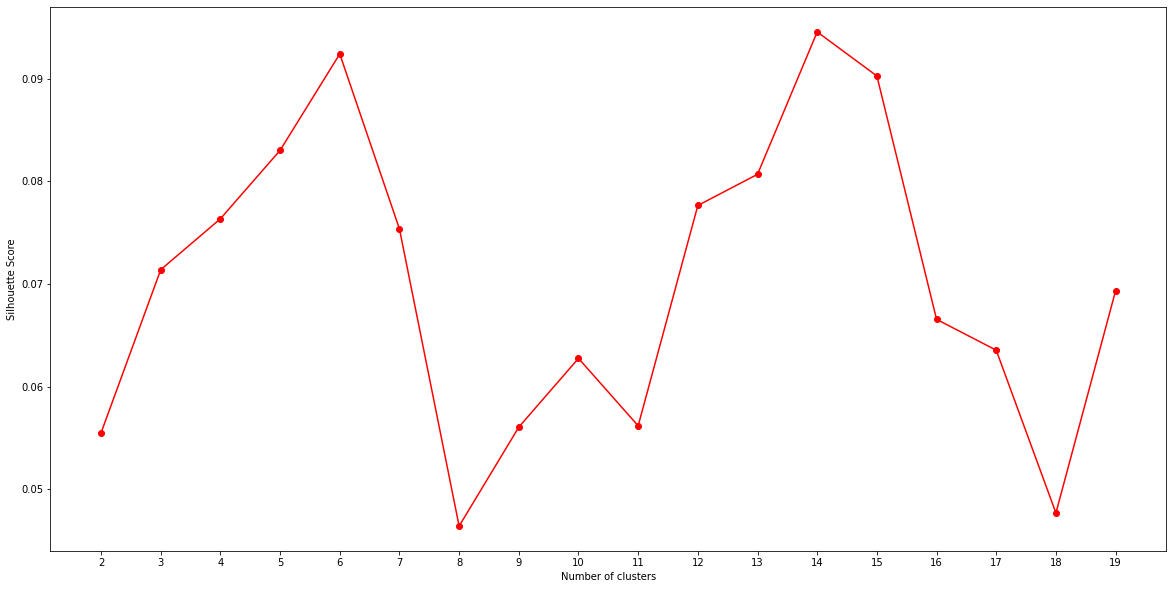

In [35]:

chn_grouped_clustering = chn_grouped.drop('Neighborhood', 1)

max_score = 20
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(chn_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(chn_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()



#Model Evaluation

####The model is evaluated by silhouette metrics and an optimal value of K is chosen.

In [36]:
#Cluster neighbourhoods
# set number of clusters
kclusters = 14

chn_grouped_clustering = chn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([11,  2,  2,  2, 10,  0,  2,  7, 11,  2], dtype=int32)

In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chn_merged = chennai_data

# merge chn_grouped with chn_data to add latitude/longitude for each neighborhood
chn_merged = chn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

chn_merged.head() # check the last columns


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,12.997222,80.256944,2.0,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Breakfast Spot,Dessert Shop,Café,Sandwich Place,Fried Chicken Joint,Fruit & Vegetable Store,Middle Eastern Restaurant
1,Adyar Signal,13.006389,80.257500,2.0,Indian Restaurant,North Indian Restaurant,Coffee Shop,Italian Restaurant,Bookstore,Electronics Store,Clothing Store,Fast Food Restaurant,Rock Club,Movie Theater
2,Alandur,13.007778,80.209722,2.0,Bus Station,Indian Restaurant,Metro Station,Restaurant,South Indian Restaurant,Bar,Bus Line,Train,Hotel,Airport
3,Ambattur,13.110000,80.170000,10.0,Indian Chinese Restaurant,Bus Station,Fast Food Restaurant,Fried Chicken Joint,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Farmers Market,Convenience Store
4,Anna Arch,13.074444,80.218333,0.0,Fast Food Restaurant,Clothing Store,Electronics Store,Pizza Place,Bookstore,Sporting Goods Shop,Multiplex,Café,Food Court,Farmers Market


In [38]:
# chn_merged.dtypes
chn_merged.dropna(inplace=True)
chn_merged.astype({'Cluster Labels': 'int32'}).dtypes

Neighborhood               object
Latitude                  float64
Longitude                 float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [39]:
#Visualize the cluster
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chn_merged['Latitude'], chn_merged['Longitude'], chn_merged['Neighborhood'], chn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [40]:


cluster1 = chn_merged.loc[chn_merged['Cluster Labels'] == 0, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))



Chinese Restaurant             8
Café                           8
Clothing Store                 7
Food Court                     7
Pizza Place                    5
Fast Food Restaurant           5
Indian Restaurant              5
Food & Drink Shop              4
Farmers Market                 3
Eastern European Restaurant    3
dtype: int64


In [41]:
cluster2 = chn_merged.loc[chn_merged['Cluster Labels'] == 1, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))
print(venues2.value_counts().head(10))

South Indian Restaurant    9
Bar                        9
Hotel                      9
Food & Drink Shop          8
Flower Shop                8
Flea Market                7
Food Court                 6
Indian Restaurant          6
Park                       5
Café                       5
dtype: int64


In [42]:
cluster3 = chn_merged.loc[chn_merged['Cluster Labels'] == 2, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))
print(venues3.value_counts().head(10))

Indian Restaurant                39
Hotel                            21
Fast Food Restaurant             19
Chinese Restaurant               16
Café                             12
Vegetarian / Vegan Restaurant    11
South Indian Restaurant          10
Pizza Place                      10
Dessert Shop                     10
Asian Restaurant                 10
dtype: int64


In [43]:
cluster4 = chn_merged.loc[chn_merged['Cluster Labels'] == 3, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))
print(venues4.value_counts().head(10))

Train Station           8
Zoo Exhibit             6
Food & Drink Shop       6
Flower Shop             6
Food Court              5
Farmers Market          5
Restaurant              4
Flea Market             4
Fast Food Restaurant    4
Fried Chicken Joint     3
dtype: int64


In [44]:
cluster5 = chn_merged.loc[chn_merged['Cluster Labels'] == 4, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))
print(venues5.value_counts().head(10))

Flea Market               1
Furniture / Home Store    1
Farmers Market            1
Food & Drink Shop         1
Zoo Exhibit               1
Food Court                1
Men's Store               1
Flower Shop               1
Fried Chicken Joint       1
Fast Food Restaurant      1
dtype: int64


In [45]:
cluster6 = chn_merged.loc[chn_merged['Cluster Labels'] == 5, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))
print(venues6.value_counts().head(10))

Platform                   2
Electronics Store          2
Fruit & Vegetable Store    1
Light Rail Station         1
Fast Food Restaurant       1
Donut Shop                 1
Fried Chicken Joint        1
Flower Shop                1
Food Court                 1
Farmers Market             1
dtype: int64


In [46]:
cluster7 = chn_merged.loc[chn_merged['Cluster Labels'] == 6, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))
print(venues7.value_counts().head(10))

Flea Market             1
Electronics Store       1
Food & Drink Shop       1
Zoo Exhibit             1
Food Court              1
Flower Shop             1
Farmers Market          1
Fried Chicken Joint     1
Playground              1
Fast Food Restaurant    1
dtype: int64


In [47]:
cluster8 = chn_merged.loc[chn_merged['Cluster Labels'] == 7, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))
print(venues8.value_counts().head(10))

Food & Drink Shop       7
Fast Food Restaurant    7
Food Court              6
Flower Shop             5
Bus Station             5
Fried Chicken Joint     5
Department Store        5
Zoo Exhibit             4
Flea Market             4
Bakery                  3
dtype: int64


In [48]:
cluster9 = chn_merged.loc[chn_merged['Cluster Labels'] == 8, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues9 = (cluster9['1st Most Common Venue'].append(
    cluster9['2nd Most Common Venue']).append(
    cluster9['3rd Most Common Venue']).append(
    cluster9['4th Most Common Venue']).append(
    cluster9['5th Most Common Venue']).append(
    cluster9['6th Most Common Venue']).append(
    cluster9['7th Most Common Venue']).append(
    cluster9['8th Most Common Venue']).append(
    cluster9['9th Most Common Venue']).append(
    cluster9['10th Most Common Venue']))
print(venues9.value_counts().head(10))

Flea Market             1
Electronics Store       1
Fast Food Restaurant    1
Food & Drink Shop       1
Zoo Exhibit             1
Food Court              1
Flower Shop             1
Farmers Market          1
Fried Chicken Joint     1
Airport Terminal        1
dtype: int64


In [49]:
cluster10 = chn_merged.loc[chn_merged['Cluster Labels'] == 9, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues10 = (cluster10['1st Most Common Venue'].append(
    cluster10['2nd Most Common Venue']).append(
    cluster10['3rd Most Common Venue']).append(
    cluster10['4th Most Common Venue']).append(
    cluster10['5th Most Common Venue']).append(
    cluster10['6th Most Common Venue']).append(
    cluster10['7th Most Common Venue']).append(
    cluster10['8th Most Common Venue']).append(
    cluster10['9th Most Common Venue']).append(
    cluster10['10th Most Common Venue']))
print(venues10.value_counts().head(10))

Flea Market               1
Furniture / Home Store    1
Farmers Market            1
Bakery                    1
Zoo Exhibit               1
Food Court                1
Flower Shop               1
Fried Chicken Joint       1
Fast Food Restaurant      1
Food & Drink Shop         1
dtype: int64


In [50]:
cluster11 = chn_merged.loc[chn_merged['Cluster Labels'] == 10, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues11 = (cluster11['1st Most Common Venue'].append(
    cluster11['2nd Most Common Venue']).append(
    cluster11['3rd Most Common Venue']).append(
    cluster11['4th Most Common Venue']).append(
    cluster11['5th Most Common Venue']).append(
    cluster11['6th Most Common Venue']).append(
    cluster11['7th Most Common Venue']).append(
    cluster11['8th Most Common Venue']).append(
    cluster11['9th Most Common Venue']).append(
    cluster11['10th Most Common Venue']))
print(venues11.value_counts().head(10))

Flea Market                  1
Farmers Market               1
Food & Drink Shop            1
Indian Chinese Restaurant    1
Food Court                   1
Flower Shop                  1
Fried Chicken Joint          1
Bus Station                  1
Convenience Store            1
Fast Food Restaurant         1
dtype: int64


In [51]:
cluster12 = chn_merged.loc[chn_merged['Cluster Labels'] == 11, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues12 = (cluster12['1st Most Common Venue'].append(
    cluster12['2nd Most Common Venue']).append(
    cluster12['3rd Most Common Venue']).append(
    cluster12['4th Most Common Venue']).append(
    cluster12['5th Most Common Venue']).append(
    cluster12['6th Most Common Venue']).append(
    cluster12['7th Most Common Venue']).append(
    cluster12['8th Most Common Venue']).append(
    cluster12['9th Most Common Venue']).append(
    cluster12['10th Most Common Venue']))
print(venues12.value_counts().head(10))

Indian Restaurant        9
Flower Shop              8
Food Court               8
Flea Market              7
Food & Drink Shop        7
Fast Food Restaurant     7
Farmers Market           6
General Entertainment    3
Fried Chicken Joint      3
Dessert Shop             3
dtype: int64


In [52]:
cluster13 = chn_merged.loc[chn_merged['Cluster Labels'] == 12, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues13 = (cluster13['1st Most Common Venue'].append(
    cluster13['2nd Most Common Venue']).append(
    cluster13['3rd Most Common Venue']).append(
    cluster13['4th Most Common Venue']).append(
    cluster13['5th Most Common Venue']).append(
    cluster13['6th Most Common Venue']).append(
    cluster13['7th Most Common Venue']).append(
    cluster13['8th Most Common Venue']).append(
    cluster13['9th Most Common Venue']).append(
    cluster13['10th Most Common Venue']))
print(venues13.value_counts().head(10))

Flea Market             1
Electronics Store       1
Fast Food Restaurant    1
Food & Drink Shop       1
Zoo Exhibit             1
Food Court              1
Flower Shop             1
Farmers Market          1
Gym Pool                1
Golf Course             1
dtype: int64


In [53]:
cluster14 = chn_merged.loc[chn_merged['Cluster Labels'] == 13, chn_merged.columns[[0] + 
                                                                                    list(range(4, chn_merged.shape[1]))]]
venues14 = (cluster14['1st Most Common Venue'].append(
    cluster14['2nd Most Common Venue']).append(
    cluster14['3rd Most Common Venue']).append(
    cluster14['4th Most Common Venue']).append(
    cluster14['5th Most Common Venue']).append(
    cluster14['6th Most Common Venue']).append(
    cluster14['7th Most Common Venue']).append(
    cluster14['8th Most Common Venue']).append(
    cluster14['9th Most Common Venue']).append(
    cluster14['10th Most Common Venue']))
print(venues14.value_counts().head(10))

Juice Bar                    3
Hyderabadi Restaurant        3
Middle Eastern Restaurant    3
Flea Market                  3
Food & Drink Shop            3
Food Court                   3
Flower Shop                  3
Indian Restaurant            2
Fried Chicken Joint          2
Fast Food Restaurant         2
dtype: int64


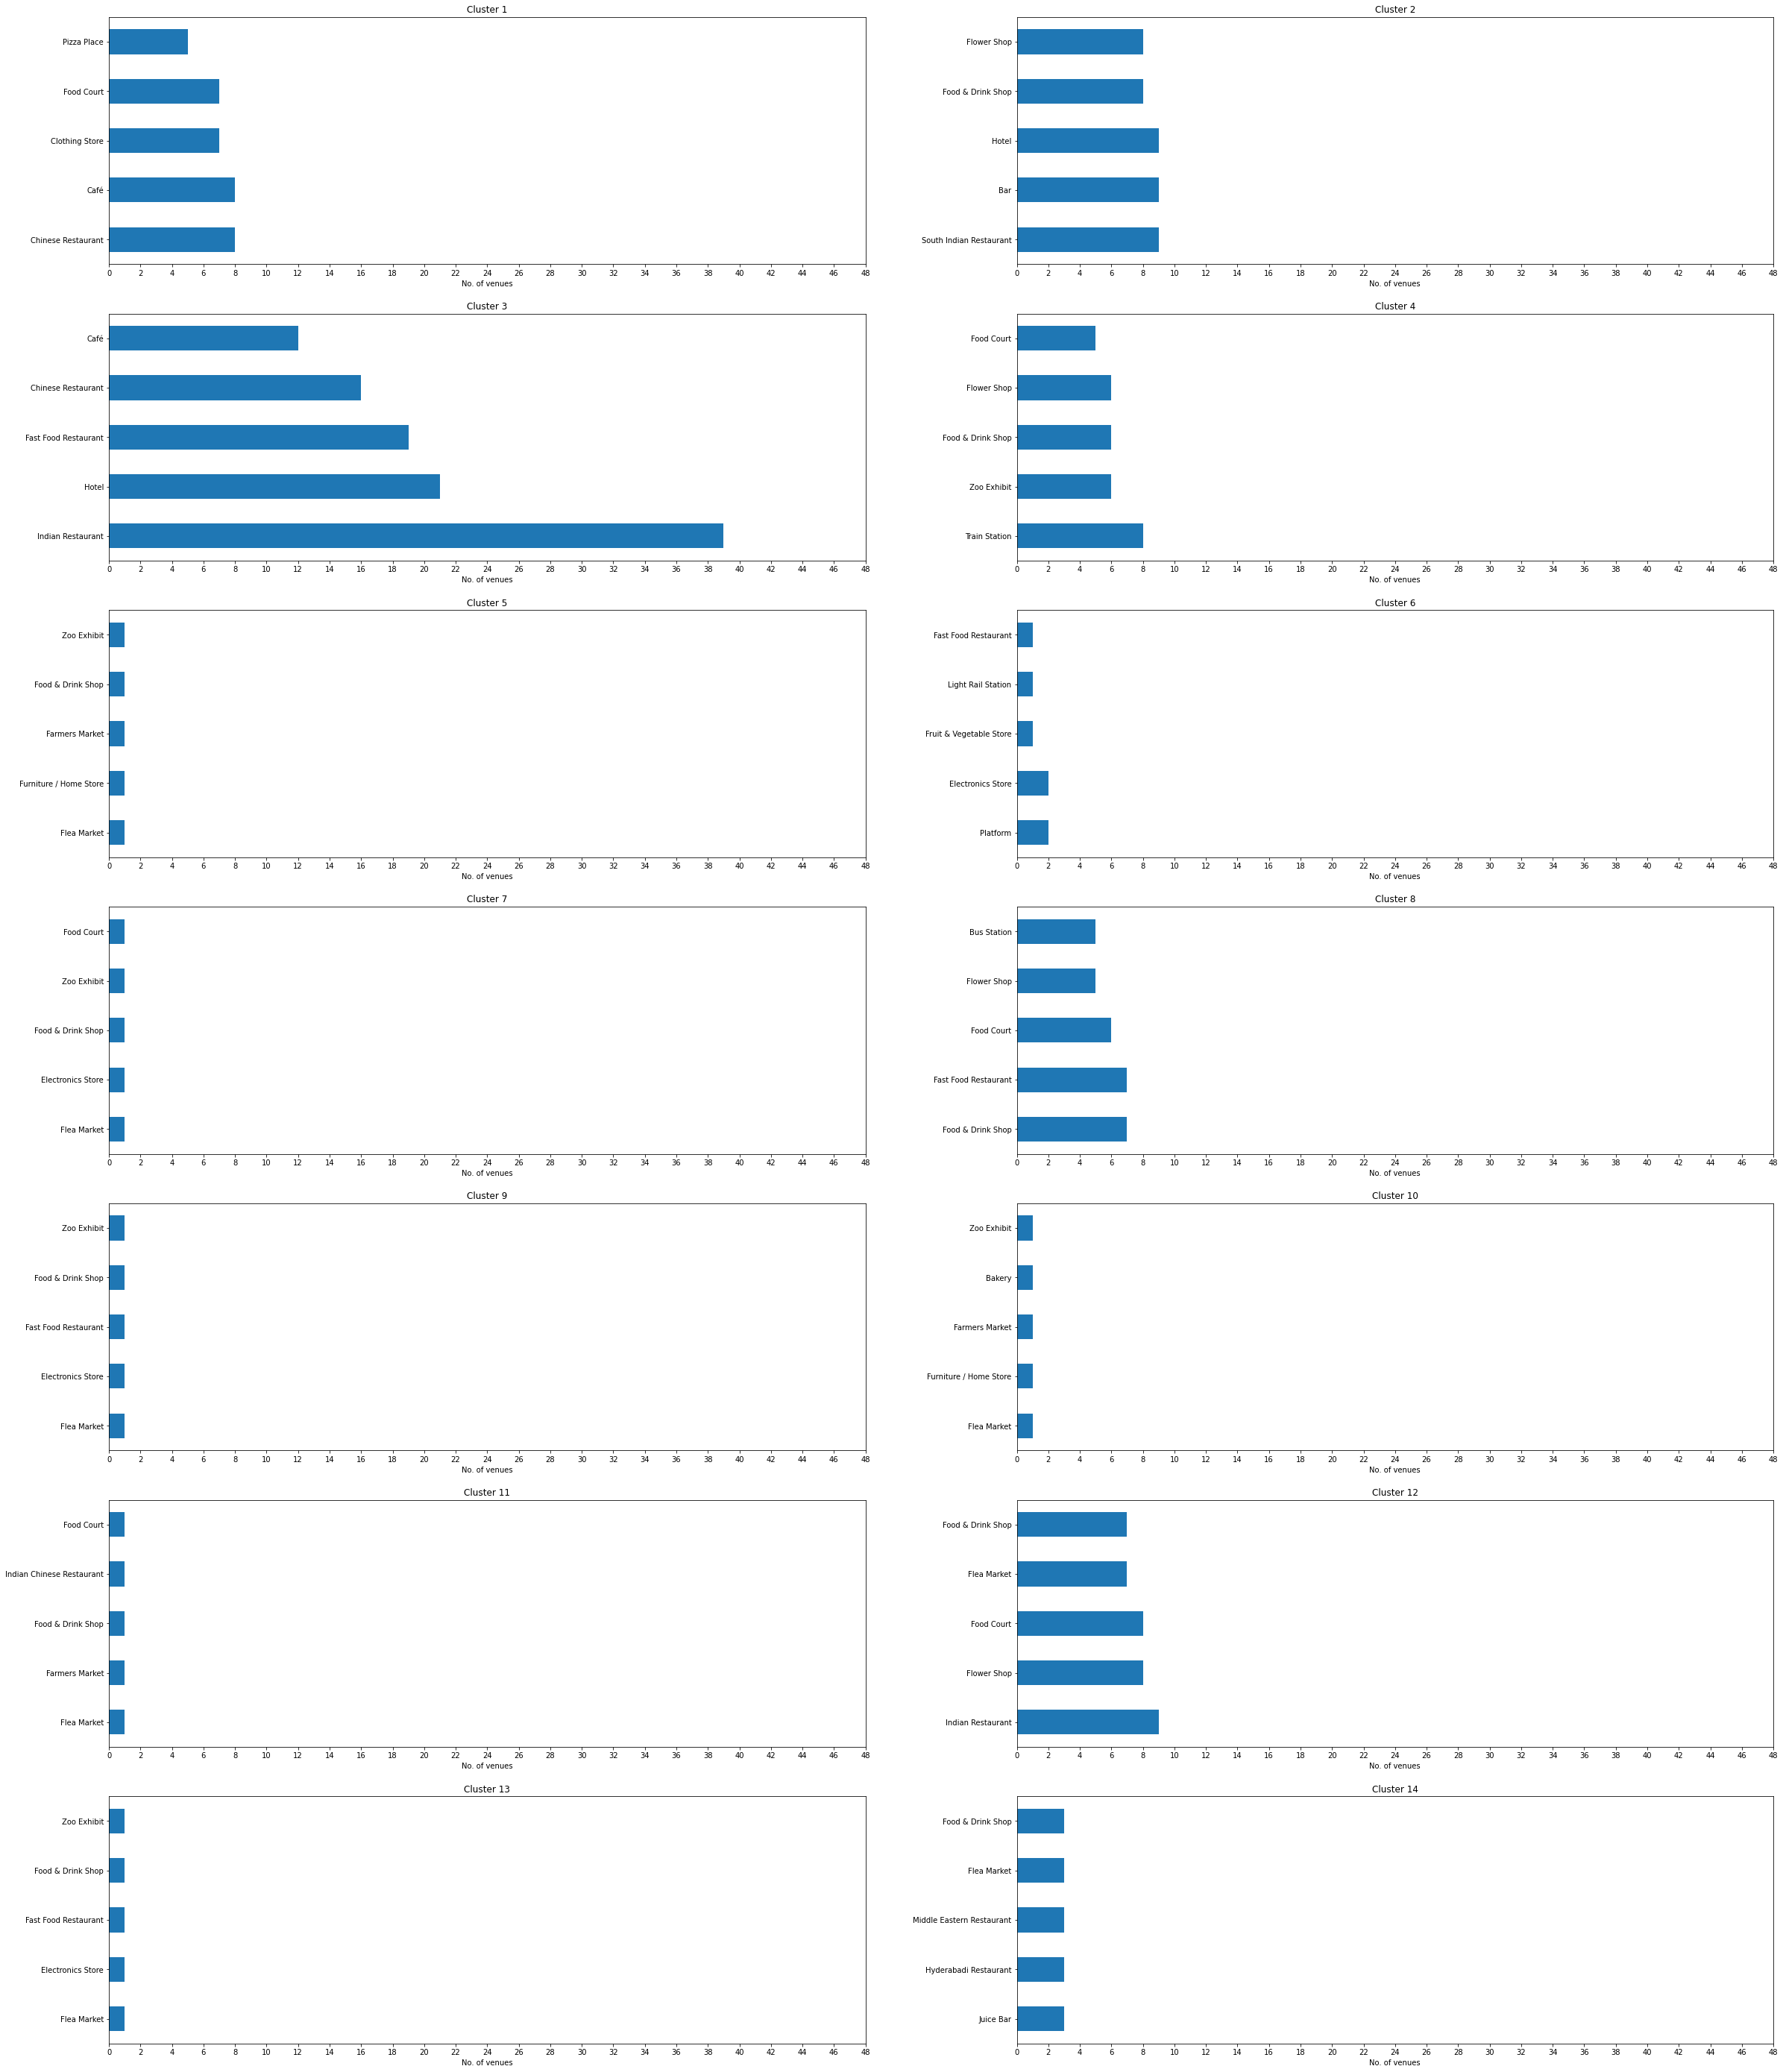

In [55]:
#Lets visulaize the top 5 most common venue categories in each of the cluster.


df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8, venues9, venues10, venues11, venues12, venues13, venues14]
fig, axes = plt.subplots(7, 2)
# fig.delaxes(axes[2,1])
count = 0
for r in range(7):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(40,50))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 50, 2))
        plt.xlabel('No. of venues')
        count += 1






In [ ]:
df = chn_merged.copy([['Cluster Labels', 'Neighborhood']])
a = df.groupby(['Cluster Labels'])['Neighborhood'].value_counts()
a

Cluster Labels  Neighborhood                          
0.0             Ambattur                                  1
                Villivakkam                               1
1.0             Alandur                                   1
                Anna University Entrance                  1
                CIPET                                     1
                Chennai Mofussil Bus Terminas (CMBT)      1
                Chola                                     1
                Egmore Railway Station                    1
                Ethiraj College                           1
                Gemini Flyover                            1
                Guindy Railway Station                    1
                HTL Colony                                1
                Isphani                                   1
                Kamarajar Arangam                         1
                MIOT Hospital                             1
                Minambakkam                  

#Result Analysis:

####It can be observed that clusters 1-4, 8, 11,12 and 14 has quite a high number of food outlets. Though the count seems less in clusters 5,6,7 and 9, it has good number of varieties. It is not be wise to open a cafe in such regions.

####In order to avoid heavy competition cluster 10 and 13 shall be considered.
####Further analysing it is observed that cluster 10 is highly dense compared to that of cluster 13. Opening a cafe in dense region is highly recommended. 


In [56]:
# create map
chennai_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chn_merged['Latitude'], chn_merged['Longitude'], chn_merged['Neighborhood'], chn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(chennai_clusters_map)
       
chennai_clusters_map